### Imports

In [70]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta, date
import uuid
import matplotlib.pyplot as plt
import matplotlib
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import Polygon as Polygon2
# import contextily as ctx
from sklearn.cluster import KMeans
import folium
from glob import glob
from sqlalchemy import create_engine

### Helper Functions

In [90]:
def get_one_day(df, date):
    return df[df['Date'] == date].copy()

def get_dates_list(st_date,end_date):
    dates = []
    start = datetime.datetime.strptime(st_date, "%Y-%m-%d")
    end = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    date_array = (start + datetime.timedelta(days=x) for x in range(0, (end-start).days+1))
    for date_object in date_array:
        dates.append(date_object.strftime("%Y-%m-%d"))
    return dates

def get_many_days(df, dates):
    eachday = []
    for i in dates:
        eachday.append(df[df['Date']==i])
    return pd.concat(eachday,ignore_index=True)

def weekend_dates(dates):
    weekend_dts = []
    for i in dates:
        year, month, day = (int(x) for x in i.split('-'))    
        ans = datetime.date(year, month, day)
        if (ans.weekday()==5) or (ans.weekday()==6):
            weekend_dts.append(i)
    return weekend_dts

def weekday_dates(dates):
    weekday_dts = []
    for i in dates:
        year, month, day = (int(x) for x in i.split('-'))    
        ans = datetime.date(year, month, day)
        if (ans.weekday()!=5) and (ans.weekday()!=6):
            weekday_dts.append(i)
    return weekday_dts

def fix_dtypes(df):
    int_cols = ['battery_level', 'estimated_range']
    float_cols = ['latitude', 'longitude']
    df = df.astype({col: 'int32' for col in int_cols})
    df = df.astype({col: 'float32' for col in float_cols})
    #Combining date, time column to datetime
    df['date_time'] = df['Date'].map(str) + " " + df["Time"].map(str)
    df['date_time'] = pd.to_datetime(df['date_time'])
    return df

def groupby_columns(df):
    df.sort_values(by='date_time', inplace=True)
    df = df.groupby(grpby_var).agg({'id':'size','latitude':['first', 'last'],
                                                    'longitude':['first', 'last'],
                                                    'date_time':['min', 'max']
                                                    }).reset_index()
    # rename columns
    df.columns = grpby_var + ["_".join(x) for x in df.columns[len(grpby_var):].ravel()]
    df['time_diff_hrs'] = (df['date_time_max'] - df['date_time_min'])/ np.timedelta64(1, 'h')
    return df.copy()

def compute_haverstine(df, lat1, long1, lat2, long2):
    # Compute distance between two points
    # https://stackoverflow.com/questions/25767596/vectorised-haversine-formula-with-a-pandas-dataframe
    df['lat_rad'], df['lng_rad'] = np.radians(df[lat1]), np.radians(df[long1])
    
    df['dLON'] = df['lng_rad'] - np.radians(df[long2])
    df['dLAT'] = df['lat_rad'] - np.radians(df[lat2])
    df['distance_km'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 +\
                                                  np.cos(np.radians(df[lat2])) * 
                                                  np.cos(df['lat_rad']) * 
                                                  np.sin(df['dLON']/2)**2))
    
    df['distance_miles'] = df['distance_km'] * 0.621371
    df.drop(['dLON', 'dLAT', 'distance_km', 'lat_rad', 'lng_rad'], axis=1, inplace = True)
    return df.copy()

def get_bearing(p1, p2):
    # credit: https://medium.com/@bobhaffner/folium-lines-with-arrows-25a0fe88e4e
    '''
    Returns compass bearing from p1 to p2
    
    Parameters
    p1 : namedtuple with lat lon
    p2 : namedtuple with lat lon
    
    Return
    compass bearing of type float
    
    Notes
    Based on https://gist.github.com/jeromer/2005586
    '''
    
    long_diff = np.radians(p2.lon - p1.lon)
    
    lat1 = np.radians(p1.lat)
    lat2 = np.radians(p2.lat)
    
    x = np.sin(long_diff) * np.cos(lat2)
    y = (np.cos(lat1) * np.sin(lat2) 
        - (np.sin(lat1) * np.cos(lat2) 
        * np.cos(long_diff)))
    bearing = np.degrees(np.arctan2(x, y))
    
    # adjusting for compass bearing
    if bearing < 0:
        return bearing + 360
    return bearing

def get_arrows(locations, color='blue', size=6, n_arrows=3):
    from collections import namedtuple
    # credit: https://medium.com/@bobhaffner/folium-lines-with-arrows-25a0fe88e4e
    '''
    Get a list of correctly placed and rotated 
    arrows/markers to be plotted
    
    Parameters
    locations : list of lists of lat lons that represent the 
                start and end of the line. 
                eg [[41.1132, -96.1993],[41.3810, -95.8021]]
    arrow_color : default is 'blue'
    size : default is 6
    n_arrows : number of arrows to create.  default is 3
    Return
    list of arrows/markers
    '''
    
    Point = namedtuple('Point', field_names=['lat', 'lon'])
    
    # creating point from our Point named tuple
    p1 = Point(locations[0][0], locations[0][1])
    p2 = Point(locations[1][0], locations[1][1])
    
    # getting the rotation needed for our marker.  
    # Subtracting 90 to account for the marker's orientation
    # of due East(get_bearing returns North)
    rotation = get_bearing(p1, p2) - 90
    
    # get an evenly space list of lats and lons for our arrows
    # note that I'm discarding the first and last for aesthetics
    # as I'm using markers to denote the start and end
    arrow_lats = np.linspace(p1.lat, p2.lat, n_arrows + 2)[1:n_arrows+1]
    arrow_lons = np.linspace(p1.lon, p2.lon, n_arrows + 2)[1:n_arrows+1]
    
    arrows = []
    
    #creating each "arrow" and appending them to our arrows list
    for points in zip(arrow_lats, arrow_lons):
        arrows.append(folium.RegularPolygonMarker(location=points, 
                      fill_color=color, number_of_sides=3, 
                      radius=size, rotation=rotation))
    return arrows

### Read in Data

In [3]:
# Creating a connection with the database
engine = create_engine('postgresql://himanshuagarwal:@localhost/scooterapi')

# 1. Reading all data from database onto a dataframe 'df'.
df  = pd.read_sql_query('select * FROM birds_dc',con=engine)
df['Date'] = df['Date'].astype(str)

In [ ]:
"""" This cell and below is code RK wrote to get data"""

""" dat_folder = '../../sample_data/'
all_files = glob(dat_folder + '*.csv')"""

In [ ]:
"""# Concat all files
li = []
colsss = ['Date', 'Origin_Dist', 'Time', 'area_key', 'battery_level', 'bounty_id', 'captive',
              'code', 'estimated_range', 'id', 'latitude', 'longitude', 'model', 'nest_id', 'vehicle_class']
for idx, filename in enumerate(all_files):
    print(idx)
    try:
        _ = pd.read_csv(filename)
#       _ = pd.read_csv(filename, index_col=None, header=0)
        _.reindex(sorted(colsss))
        print(len(_))
        print(_.columns)
        li.append(_)
    except Exception as e:
        print(e.args)

df = pd.concat(li)"""

### Analyze one day of Data

In [4]:
df_one_day = get_one_day(df, '2019-10-06')

print('Data cleaning (formats)')
int_cols = ['battery_level', 'estimated_range']
float_cols = ['latitude', 'longitude']

# Fix dtypes
df_one_day = df_one_day.astype({col: 'int32' for col in int_cols})
df_one_day = df_one_day.astype({col: 'float32' for col in float_cols})

df_one_day['date_time'] = df_one_day['Date'].map(str) + " " + df_one_day["Time"].map(str)
df_one_day['date_time'] = pd.to_datetime(df_one_day['date_time'])
df_one_day.head()

Data cleaning (formats)


,Date,Origin_Dist,Time,area_key,battery_level,bounty_id,captive,code,estimated_range,id,latitude,longitude,model,nest_id,vehicle_class,date_time
906071,2019-10-06,0.316459,04:03:02,F461754DC547D80D5B8E77A5018FC6E8,73,None,False,None,8905,77948342-3216-435c-9a86-a8272ac64c76,38.937881,-77.088341,bd,None,scooter,2019-10-06 04:03:02
906072,2019-10-06,0.550375,04:03:02,F461754DC547D80D5B8E77A5018FC6E8,18,fbea8ba4-83bb-4f3b-bbe8-05d79ec74ecb,False,None,2192,494330fa-956f-49ca-896f-8803962b31ba,38.931728,-77.084740,bd,None,scooter,2019-10-06 04:03:02
906073,2019-10-06,0.555204,04:03:02,F461754DC547D80D5B8E77A5018FC6E8,18,None,False,None,2192,dbd57801-7414-4f8c-bfca-259898444a51,38.927715,-77.093651,bd,None,scooter,2019-10-06 04:03:02
906074,2019-10-06,0.586691,04:03:02,F461754DC547D80D5B8E77A5018FC6E8,33,None,False,None,3973,023eeffd-4023-4856-b39e-e4a2d2fbab20,38.932312,-77.103500,bd,None,scooter,2019-10-06 04:03:02
906075,2019-10-06,0.817411,04:03:02,F461754DC547D80D5B8E77A5018FC6E8,42,590fb85d-8909-49d6-957a-890e17a96b2c,False,None,5069,c0ed9b51-b4aa-4dcc-b77d-edc27b913219,38.947613,-77.093597,bd,None,scooter,2019-10-06 04:03:02


In [5]:
grpby_var = ['id']
print('Summarize activity by', grpby_var)
# summary by bird id
df_one_day.sort_values(by='date_time', inplace=True)
df_one_day_grp = df_one_day.groupby(grpby_var).agg({'id':'size',
                                                    'latitude':['first', 'last'],
                                                    'longitude':['first', 'last'],
                                                    'date_time':['min', 'max']
                                                    }).reset_index()
# rename columns
df_one_day_grp.columns = grpby_var + ["_".join(x) for x in df_one_day_grp.columns[len(grpby_var):].ravel()]

Summarize activity by ['id']


In [6]:
df_one_day_grp.head()

,id,id_size,latitude_first,latitude_last,longitude_first,longitude_last,date_time_min,date_time_max
0,00224a92-3563-4a97-9652-a016a6140ab1,45,38.856125,38.856125,-77.050224,-77.050224,2019-10-06 10:15:28,2019-10-06 14:16:43
1,00396b09-42af-4965-97b6-7fdae160e7ab,2,38.918373,38.918373,-77.022903,-77.022903,2019-10-06 18:08:19,2019-10-06 18:13:52
2,006e822c-68e9-4156-bf93-a6eafb0ec32e,11,38.892269,38.892406,-77.031929,-77.031891,2019-10-06 16:29:28,2019-10-06 17:24:17
3,00711ff1-7f96-47c1-a96d-afb1be8db9d7,3,38.877048,38.877048,-77.109741,-77.109741,2019-10-06 15:34:15,2019-10-06 15:45:14
4,007564f2-972a-44ac-b44e-bbee4f23b9c3,4,38.903225,38.903378,-77.044914,-77.044830,2019-10-06 15:34:17,2019-10-06 15:50:45


In [8]:
df_one_day_grp['time_diff_hrs'] = (df_one_day_grp['date_time_max'] -\
                                      df_one_day_grp['date_time_min'])/ np.timedelta64(1, 'h')
df_one_day_grp = compute_haverstine(df_one_day_grp, 'latitude_first', 'longitude_first',
                                    'latitude_last', 'longitude_last')

In [10]:
df_one_day_grp.head(2)

,id,id_size,latitude_first,latitude_last,longitude_first,longitude_last,date_time_min,date_time_max,time_diff_hrs,distance_miles
0,00224a92-3563-4a97-9652-a016a6140ab1,45,38.856125,38.856125,-77.050224,-77.050224,2019-10-06 10:15:28,2019-10-06 14:16:43,4.020833,0.0
1,00396b09-42af-4965-97b6-7fdae160e7ab,2,38.918373,38.918373,-77.022903,-77.022903,2019-10-06 18:08:19,2019-10-06 18:13:52,0.092500,0.0


In [9]:
df_one_day_grp.describe()

,id_size,latitude_first,latitude_last,longitude_first,longitude_last,time_diff_hrs,distance_miles
count,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000
mean,39.011393,38.892647,38.892609,-77.047386,-77.047340,3.492204,0.025334
std,51.527569,0.028711,0.028681,0.036468,0.036491,4.725003,0.149249
min,1.000000,38.792660,38.792660,-77.140594,-77.140633,0.000000,0.000000
25%,5.000000,38.882740,38.882759,-77.074394,-77.074303,0.373056,0.000000
50%,17.000000,38.896492,38.896492,-77.043442,-77.043358,1.525833,0.002665
75%,52.000000,38.908688,38.908688,-77.022842,-77.022881,4.651111,0.014844
max,220.000000,38.972149,38.972149,-76.925484,-76.925201,19.936111,6.062137


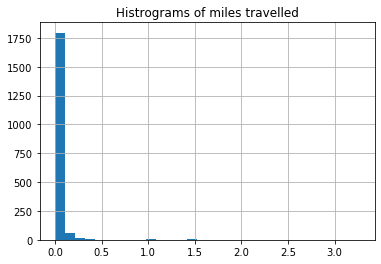

In [11]:
df_one_day_grp[df_one_day_grp['time_diff_hrs'] > 1]['distance_miles'].hist(bins=30)
plt.title('Histrograms of miles travelled')
plt.show()

### Cluster Scooters that are Stationary (one day)

In [17]:
# Define stationary
cond_stationary_1 = (df_one_day_grp['time_diff_hrs'] > 4)
cond_stationary_2 = (df_one_day_grp['distance_miles'] < 0.50)

cond_1_df = df_one_day_grp[cond_stationary_1]
stationary_df = df_one_day_grp[cond_stationary_1 & cond_stationary_2]
non_stationary_df = df_one_day_grp[~cond_stationary_2]

print('Percent of data that meet cond_1: {:.1f}%'.format(len(cond_1_df)/len(df_one_day_grp) * 100))
print('Percent of data that is stationary, given cond_1: {:.1f}%'.format(len(stationary_df)/len(cond_1_df) * 100))
print('Count of non-stationary scooters:', len(non_stationary_df))

Percent of data that meet cond_1: 28.8%
Percent of data that is stationary, given cond_1: 99.0%
Count of non-stationary scooters: 15


In [18]:
def generate_map(df, lat_col, long_col, m=None, color='crimson', center_loc=[38.95026, -77.09355]):
    if not m:
        m = folium.Map(location=center_loc)

    for i in range(0, len(df)-1):
        folium.Circle(
        location=[df[lat_col].iloc[i], df[long_col].iloc[i]],
        radius=5,
        color=color,
        fill=False,
        ).add_to(m)
    return m

In [25]:
print('Mapping stationary scooters')
m_stationary = generate_map(stationary_df, 'latitude_first', 'longitude_first')
m_stationary

Mapping stationary scooters


In [19]:
print('Mapping non-stationary scooters, first lat/long')
m_non_stationary_first = generate_map(non_stationary_df, 'latitude_first', 'longitude_first')
m_non_stationary_last = generate_map(non_stationary_df, 'latitude_last', 'longitude_last',
                                     m=m_non_stationary_first, color='blue')

Mapping non-stationary scooters, first lat/long


In [20]:
m_non_stationary_last

In [21]:
non_stationary_df.head()

,id,id_size,latitude_first,latitude_last,longitude_first,longitude_last,date_time_min,date_time_max,time_diff_hrs,distance_miles
435,1abf63b5-1125-416c-ab81-a0dfe8241ad2,128,38.858967,38.869370,-76.989243,-77.010712,2019-10-06 04:03:13,2019-10-06 23:37:30,19.571389,1.359437
692,2a2d2c71-591f-443e-b5b8-dfd91d816b91,56,38.907928,38.887981,-77.025414,-77.015968,2019-10-06 18:47:02,2019-10-06 23:48:19,5.021389,1.467722
863,35610f45-1d6d-44f3-aa53-ae4fcad649df,146,38.929909,38.912540,-77.010574,-77.026161,2019-10-06 04:03:08,2019-10-06 23:59:05,19.932500,1.462716
973,3c136dcf-f990-4bd8-84be-e3ac1c2b66b0,4,38.897408,38.904404,-77.082832,-77.069534,2019-10-06 16:40:18,2019-10-06 16:56:44,0.273889,0.862501
1124,45365b23-9e75-497a-b4ba-cec4b8d3826a,167,38.960709,38.930107,-77.022133,-76.975822,2019-10-06 04:03:05,2019-10-06 23:59:15,19.936111,3.263288


In [22]:
def generate_map_trip(df, lat_col_start, long_col_start, lat_col_end, long_col_end,
                     m=None, color='blue', center_loc=[38.95026, -77.09355]):
    if not m:
        print('creating a new map...')
        m = folium.Map(location=center_loc)

    for i in range(0, len(df)-1):
        # Add start and end point
        trip_start_end_point = [(df[lat_col_start].iloc[i], df[long_col_start].iloc[i]),
                          (df[lat_col_end].iloc[i], df[long_col_end].iloc[i])]
        folium.PolyLine(locations=trip_start_end_point, color=color, opacity=0.3).add_to(m)
        # Draw arrows 
        arrows = get_arrows(locations=trip_start_end_point, n_arrows=3)
        for arrow in arrows:
            arrow.add_to(m)
    return m

In [23]:
m_move = generate_map_trip(non_stationary_df, 'latitude_first', 'longitude_first',
                           'latitude_last', 'longitude_last')

creating a new map...


In [24]:
m_move

### Analyze multiple days of data

In [85]:
dates = get_dates_list('2019-09-30','2019-10-13')
weekend_dates = weekend_dates(dates)
weekday_dates = weekday_dates(dates)

df_multiple_days = get_many_days(df, dates)
df_week_days = get_many_days(df, weekday_dates)
df_weekend_days = get_many_days(df, weekend_dates)

#Fixing dtypes
print('Data cleaning (formats)')
df_multiple_days = fix_dtypes(df_multiple_days)
df_week_days = fix_dtypes(df_week_days)
df_weekend_days = fix_dtypes(df_weekend_days)

Data cleaning (formats)


In [89]:
df_weekend_days['Date'].unique()

array(['2019-10-05', '2019-10-06', '2019-10-12', '2019-10-13'],
      dtype=object)

In [91]:
grpby_var = ['Date','id']
print('Summarize activity by', grpby_var)
# summary by bird id
df_multiple_days_grp = groupby_columns(df_multiple_days)
df_week_days_grp = groupby_columns(df_week_days)
df_weekend_days_grp = groupby_columns(df_weekend_days)

Summarize activity by ['Date', 'id']


In [95]:
df_weekend_days_grp.head()

,Date,id,id_size,latitude_first,latitude_last,longitude_first,longitude_last,date_time_min,date_time_max,time_diff_hrs
0,2019-10-05,00047559-9d86-4a9f-904d-b61a8575fcd4,13,38.880566,38.880566,-77.085831,-77.085831,2019-10-05 10:55:18,2019-10-05 12:00:43,1.090278
1,2019-10-05,00110301-5d82-447e-b921-f4958bc5de71,7,38.911137,38.911137,-77.002579,-77.002579,2019-10-05 13:38:29,2019-10-05 14:10:59,0.541667
2,2019-10-05,001a2d6a-ccf6-434f-8003-97a2c036da15,82,38.904209,38.903999,-77.062828,-77.063034,2019-10-05 09:11:51,2019-10-05 16:32:42,7.347500
3,2019-10-05,005f846c-e758-4c8e-80bb-90dc1d182f9e,7,38.905323,38.905323,-77.058006,-77.058006,2019-10-05 16:32:42,2019-10-05 17:05:19,0.543611
4,2019-10-05,006e2191-c2f7-4f2e-b0f6-4bfc934bff00,10,38.899529,38.899529,-77.023827,-77.023827,2019-10-05 17:59:40,2019-10-05 18:48:31,0.814167


In [96]:
df_multiple_days_grp = compute_haverstine(df_multiple_days_grp, 'latitude_first', 'longitude_first',
                                    'latitude_last', 'longitude_last')
df_week_days_grp = compute_haverstine(df_week_days_grp, 'latitude_first', 'longitude_first',
                                    'latitude_last', 'longitude_last')
df_weekend_days_grp = compute_haverstine(df_weekend_days_grp, 'latitude_first', 'longitude_first',
                                    'latitude_last', 'longitude_last')

In [98]:
df_weekend_days_grp.head()

,Date,id,id_size,latitude_first,latitude_last,longitude_first,longitude_last,date_time_min,date_time_max,time_diff_hrs,distance_miles
0,2019-10-05,00047559-9d86-4a9f-904d-b61a8575fcd4,13,38.880566,38.880566,-77.085831,-77.085831,2019-10-05 10:55:18,2019-10-05 12:00:43,1.090278,0.00000
1,2019-10-05,00110301-5d82-447e-b921-f4958bc5de71,7,38.911137,38.911137,-77.002579,-77.002579,2019-10-05 13:38:29,2019-10-05 14:10:59,0.541667,0.00000
2,2019-10-05,001a2d6a-ccf6-434f-8003-97a2c036da15,82,38.904209,38.903999,-77.062828,-77.063034,2019-10-05 09:11:51,2019-10-05 16:32:42,7.347500,0.01834
3,2019-10-05,005f846c-e758-4c8e-80bb-90dc1d182f9e,7,38.905323,38.905323,-77.058006,-77.058006,2019-10-05 16:32:42,2019-10-05 17:05:19,0.543611,0.00000
4,2019-10-05,006e2191-c2f7-4f2e-b0f6-4bfc934bff00,10,38.899529,38.899529,-77.023827,-77.023827,2019-10-05 17:59:40,2019-10-05 18:48:31,0.814167,0.00000


In [99]:
df_weekend_days_grp.describe()

,id_size,latitude_first,latitude_last,longitude_first,longitude_last,time_diff_hrs,distance_miles
count,20329.000000,20329.000000,20329.000000,20329.000000,20329.000000,20329.000000,20329.000000
mean,32.945300,38.895554,38.895561,-77.047104,-77.047112,2.917639,0.026514
std,47.530671,0.026925,0.026882,0.034393,0.034371,4.333981,0.168839
min,1.000000,38.791870,38.791870,-77.146614,-77.146866,0.000000,0.000000
25%,4.000000,38.886539,38.886532,-77.071350,-77.071396,0.272222,0.000000
50%,13.000000,38.897614,38.897633,-77.041801,-77.041817,1.084444,0.003083
75%,41.000000,38.909695,38.909668,-77.024017,-77.023987,3.684444,0.015143
max,221.000000,38.974052,38.973820,-76.913338,-76.913292,19.936111,6.921039


In [101]:
df_week_days_grp.describe()

,id_size,latitude_first,latitude_last,longitude_first,longitude_last,time_diff_hrs,distance_miles
count,45610.000000,45610.000000,45610.000000,45610.000000,45610.000000,45610.000000,45610.000000
mean,38.238654,38.896317,38.896301,-77.045647,-77.045685,3.456796,0.033362
std,48.321393,0.026978,0.027027,0.036813,0.036735,4.537513,0.232972
min,1.000000,38.792419,38.792419,-77.145386,-77.145386,0.000000,0.000000
25%,6.000000,38.885339,38.885339,-77.072187,-77.072193,0.455833,0.000000
50%,20.000000,38.899181,38.899166,-77.041618,-77.041611,1.720000,0.001462
75%,50.000000,38.910351,38.910339,-77.022385,-77.022455,4.434931,0.015874
max,221.000000,38.979557,38.979557,-76.919052,-76.919052,19.945833,10.358062


/Users/himanshuagarwal/anaconda3/envs/geo_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


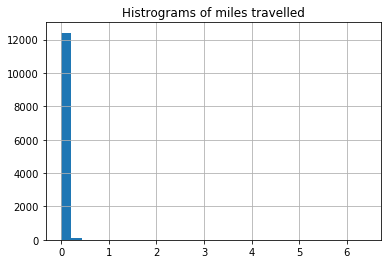

In [103]:
df_weekend_days_grp[df_week_days_grp['time_diff_hrs'] > 1]['distance_miles'].hist(bins=30)
plt.title('Histrograms of miles travelled')
plt.show()

In [110]:
# Define stationary
cond_stationary_1_weekday = (df_week_days_grp['time_diff_hrs'] > 4)
cond_stationary_2_weekday = (df_week_days_grp['distance_miles'] < 0.50)

cond_stationary_1_weekend = (df_weekend_days_grp['time_diff_hrs'] > 4)
cond_stationary_2_weekend = (df_weekend_days_grp['distance_miles'] < 0.50)

In [112]:
def stationary_scooter(df,cond_stationary_1,cond_stationary_2):
    #Stationary scooters
    cond_1_df = df[cond_stationary_1]
    stationary_df = df[cond_stationary_1 & cond_stationary_2]
    non_stationary_df = df[~cond_stationary_2]

    print('Percent of data that meet cond_1: {:.1f}%'.format(len(cond_1_df)/len(df) * 100))
    print('Percent of data that is stationary, given cond_1: {:.1f}%'.format(len(stationary_df)/len(cond_1_df) * 100))
    print('Count of non-stationary scooters:', len(non_stationary_df))
    
    return cond_1_df, stationary_df, non_stationary_df

In [113]:
print('Stats for weekday scooters:')
cond_1_df_weekday, stationary_df_weekday, non_stationary_df_weekday = stationary_scooter(df_week_days_grp,cond_stationary_1_weekday,cond_stationary_2_weekday)
print('\n')

print('Stats for weekend scooters:')
cond_1_df_weekend, stationary_df_weekend, non_stationary_df_weekend = stationary_scooter(df_weekend_days_grp,cond_stationary_1_weekend,cond_stationary_2_weekend)

Stats for weekday scooters:
Percent of data that meet cond_1: 28.6%
Percent of data that is stationary, given cond_1: 98.6%
Count of non-stationary scooters: 322


Stats for weekend scooters:
Percent of data that meet cond_1: 23.3%
Percent of data that is stationary, given cond_1: 98.7%
Count of non-stationary scooters: 94


In [ ]:
print('Mapping stationary scooters - weekend')
m_stationary = generate_map(stationary_df_weekend, 'latitude_first', 'longitude_first')
m_stationary

In [124]:
print('Mapping non-stationary scooters, first lat/long')
m_non_stationary_first = generate_map(non_stationary_df_weekend, 'latitude_first', 'longitude_first')
m_non_stationary_last = generate_map(non_stationary_df_weekend, 'latitude_last', 'longitude_last',
                                     m=m_non_stationary_first, color='blue')

Mapping non-stationary scooters, first lat/long


In [125]:
m_non_stationary_last

In [122]:
m_move = generate_map_trip(non_stationary_df_weekend, 'latitude_first', 'longitude_first',
                           'latitude_last', 'longitude_last')

creating a new map...


In [123]:
m_move